# Imports

In [1]:
#Reference: https://towardsdatascience.com/multivariate-time-series-forecasting-with-deep-learning-3e7b3e2d2bcf
import os
import yaml
import joblib
import pandas as pd
from pathlib import Path
from matplotlib import pyplot as plt
import seaborn as sns
import plotly.express as px
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import Normalizer
from sklearn.preprocessing import MinMaxScaler
from torch.utils.data import DataLoader
import torch
import time
import shap
sns.set()

os.chdir(r'C:\Users\Mubby\OneDrive - University of Kentucky/DOCS/SPRING 2022/DS 711/Capstone python/scripts')
import preprocess, train, inference, interpret

In [2]:
with open("../model/params.yaml", "r") as params_file:
    params = yaml.safe_load(params_file)

data_dir = params['data_dir']
model_dir = params['model_dir']

# Functions

In [3]:
def create_features(
        df
):
    """Creates new features."""
    
    # add date-derived features
    df['Day_Of_Week'] = pd.DatetimeIndex(df['Date']).dayofweek
    df['Month_Of_Year'] = pd.DatetimeIndex(df['Date']).month
    df['Quarter_Of_Year'] = pd.DatetimeIndex(df['Date']).quarter
    df['Day_of_Year'] = pd.DatetimeIndex(df['Date']).dayofyear
    #drop cols----
    #constants
    df = df.drop(columns = ['Date'])
    df = df.drop(columns = ['County'])
    df = df.drop(columns = ['State'])
    df = df.drop(columns = ['Age-65'])
    df = df.drop(columns = ['Income-PC'])
    df = df.drop(columns = ['Lat'])
    df = df.drop(columns = ['Long'])
    df = df.drop(columns = ['Population'])
    
    #changing
    df = df.drop(columns = ['New Deaths'])
    #df = df.drop(columns = ['Cases'])
    df = df.drop(columns = ['New Cases'])
    
    
    new_cols = ['Deaths', 'Cases', 'temp', 'humidity', 'windspeed', 'Day_Of_Week', 'Month_Of_Year', 'Quarter_Of_Year', 'Day_of_Year']
    df=df[new_cols]
    df=df.reindex(columns=new_cols)
  
    # drop rows with missing values
    df = df.dropna()
    
    return df

In [4]:
def split_data(
        df,
        train_frac
):
    train_size = int(len(df) * train_frac)
    train_df, test_df = df[:train_size], df[train_size:]

    return train_df, test_df, train_size

In [5]:
def rescale_data(
        df
):
    """Rescale all features using MinMaxScaler() to same scale, between 0 and 1."""
    
    scaler = MinMaxScaler()
    scaler = scaler.fit(df)

    df_scaled = pd.DataFrame(
        scaler.transform(df),
        index=df.index,
        columns=df.columns)

    # save trained data scaler
    joblib.dump(scaler, Path(model_dir, 'scaler.gz'))
    
    return df_scaled

# Load & Prepare Data

In [6]:
file_name = r'C:\Users\Mubby\OneDrive - University of Kentucky/DOCS/SPRING 2022/DS 711/Capstone python/covidweather.csv'
data = pd.read_csv(file_name)
data['Date'] = pd.to_datetime(data['Date'])
data

,UID,Date,County,State,Population,Lat,Long,temp,humidity,windspeed,New Deaths,Deaths,New Cases,Cases,Age-65,Income-PC
0,84001073,2020-03-01,Jefferson,AL,658573,33.555547,-86.895063,12.5,44.47,28.8,0,0,0,0,16.3,32098
1,84001073,2020-03-02,Jefferson,AL,658573,33.555547,-86.895063,14.4,85.83,19.0,0,0,0,0,16.3,32098
2,84001073,2020-03-03,Jefferson,AL,658573,33.555547,-86.895063,18.8,82.40,24.0,0,0,0,0,16.3,32098
3,84001073,2020-03-04,Jefferson,AL,658573,33.555547,-86.895063,13.3,90.78,14.5,0,0,0,0,16.3,32098
4,84001073,2020-03-05,Jefferson,AL,658573,33.555547,-86.895063,11.1,89.99,19.4,0,0,0,0,16.3,32098
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
35035,84056021,2022-02-24,Laramie,WY,99500,41.307025,-104.688750,-13.2,68.00,26.9,0,273,25,25861,16.5,35190
35036,84056021,2022-02-25,Laramie,WY,99500,41.307025,-104.688750,-10.6,65.60,21.5,0,273,19,25880,16.5,35190
35037,84056021,2022-02-26,Laramie,WY,99500,41.307025,-104.688750,-6.9,45.00,22.6,0,273,0,25880,16.5,35190
35038,84056021,2022-02-27,Laramie,WY,99500,41.307025,-104.688750,2.5,27.10,37.1,0,273,0,25880,16.5,35190


# Visualize each Location

In [7]:
# # #visualize
# vdata = data.copy()
# vdata['C-State'] = vdata[['County', 'State']].apply(lambda x: ','.join(x), axis=1)
# vdata.drop(['County', 'State'], axis=1, inplace=True)


# for i in vdata['C-State'].unique():
#     subset = vdata[(vdata['C-State'] == i)]
#     subsetV = subset.copy()
#     subsetV['Moving_Average'] = subsetV['New Deaths'].rolling(10).mean()
#     fig = px.line(subsetV, x="Date", y=["New Deaths","Moving_Average"], title = i, template = 'plotly_dark')
#     fig.show()

# For each UID

Processing Location:  Jefferson AL
Starting with model training...
Completed.
UID Time Elapsed: 51.69064450263977
Processing Location:  Maricopa AZ
Starting with model training...
Early stopping.
Completed.
UID Time Elapsed: 38.43790650367737
Processing Location:  Pulaski AR
Starting with model training...
Early stopping.
Completed.
UID Time Elapsed: 35.73971104621887
Processing Location:  Los Angeles CA
Starting with model training...
Completed.
UID Time Elapsed: 35.89179730415344
Processing Location:  Denver CO
Starting with model training...
Completed.
UID Time Elapsed: 36.176727533340454
Processing Location:  Fairfield CT
Starting with model training...
Completed.
UID Time Elapsed: 37.4921817779541
Processing Location:  New Castle DE
Starting with model training...
Completed.
UID Time Elapsed: 37.13246273994446
Processing Location:  Miami-Dade FL
Starting with model training...
Early stopping.
Completed.
UID Time Elapsed: 36.37230682373047
Processing Location:  Fulton GA
Starting w

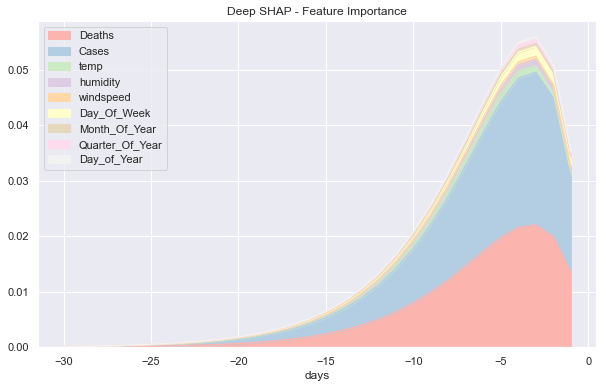

In [8]:
shap_lyst = []
mae_lyst = []
rmse_lyst = []
#---for each
for x in data['UID'].unique():
    start = time.time()
    
    df = data[(data['UID'] == x)]
    
    
    df = df.drop(columns = ['UID'])
    
    print("Processing Location: ", df.iloc[1,1],df.iloc[1,2])
    

    #create features
    df = create_features(df)

    #split into train/test datasets (may 13th 2021)
    train_df, test_df, train_size = split_data(df, 0.6)

    #rescale
    train_df = rescale_data(train_df)
    #use scaler for test data
    scaler = joblib.load(Path(model_dir, 'scaler.gz'))
    test_df = pd.DataFrame(
        scaler.transform(test_df),
        index=test_df.index,
        columns=test_df.columns)

    #check

    #train_df = train_df.rename(columns={"temp": "Close"})    
    #test_df = test_df.rename(columns={"temp": "Close"})   


    train_df.to_csv(r'C:\Users\Mubby\OneDrive - University of Kentucky\DOCS\SPRING 2022\DS 711\Capstone python\data\train.csv', index = False)
    test_df.to_csv(r'C:\Users\Mubby\OneDrive - University of Kentucky\DOCS\SPRING 2022\DS 711\Capstone python\data\test.csv', index = False)
    
    #parameters for training
    sequence_length = 30
    batch_size = 64
    n_epochs = 20
    n_epochs_stop = 10
    label_name = 'Deaths'
    
    
    
    hist = train.train_model(train_df, test_df, label_name, sequence_length, batch_size, n_epochs, n_epochs_stop)
    
    
    #evaluate model
    predictions_descaled, labels_descaled = inference.predict(df=test_df,
                                                          label_name='Deaths',
                                                          sequence_length=sequence_length)

    predictions_descaled.shape, predictions_descaled.shape
    
    #errors
    rmsquarede = inference.rmse_return(labels_descaled, predictions_descaled)
    mactual = inference.mae_return(labels_descaled, predictions_descaled)
    
    #Feature Importances
    background_data_size = 630
    test_sample_size = 100
    sequence_length = 30
    test_df
    
    shap_values = interpret.get_important_features(
        label_name,
        background_data_size,
        test_sample_size,
        sequence_length
    )
    
    shap_lyst.append(shap_values)
    rmse_lyst.append(rmsquarede)
    mae_lyst.append(mactual)
    end = time.time()
    print("MAE: ", mactual)
    print("UID Time Elapsed:", end - start)

avgs = [sum(vals)/len(shap_lyst) for vals in zip(*shap_lyst)]

#errors

print("Avg. RMSE: ", sum(rmse_lyst) / len(rmse_lyst))
print("Avg. MAE: ", sum(mae_lyst) / len(mae_lyst))


#average feature importances for all locations
shap_plot = pd.DataFrame(avgs, columns=train_df.columns.tolist())
shap_plot['days'] = [i-31 for i in list(range(1,31))]
shap_plot.head()


shap_plot.plot.area(x='days',figsize=(10, 6), cmap='Pastel1')
plt.title("Deep SHAP - Feature Importance")
plt.show()